In [14]:
from pandas import read_feather, read_csv
from pandas import DataFrame
import numpy as np
from math import radians, cos, sin, asin, sqrt

import tensorflow as tf, keras

#print(tf.__version__)

# New York City Taxi Fare Prediction

In [15]:
def distance(lat1, lng1, lat2, lng2):
    #return distance as meter if you want km distance, remove "* 1000"
    radius = 6371

    dLat = (lat2-lat1) * np.pi / 180
    dLng = (lng2-lng1) * np.pi / 180

    lat1 = lat1 * np.pi / 180
    lat2 = lat2 * np.pi / 180

    val = np.sin(dLat/2) * np.sin(dLat/2) + np.sin(dLng/2)\
    * np.sin(dLng/2) * np.cos(lat1) * np.cos(lat2)    
    ang = 2 * np.arctan2(np.sqrt(val), np.sqrt(1-val))
    return radius * ang

## Test Sample (statistics)

In [36]:
# No missing values
test_df = read_csv('test.csv', parse_dates=["pickup_datetime"],
                  infer_datetime_format=True)
print(test_df.shape)
test_df.head()

(9914, 7)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


In [37]:
test_df['dist'] = distance(test_df['pickup_latitude'], test_df['pickup_longitude'],
                           test_df['dropoff_latitude'], test_df['dropoff_longitude'])

In [18]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273,3.435371
std,0.042774,0.033541,0.039072,0.035435,1.278747,3.972374
min,-74.252193,40.573143,-74.263242,40.568973,1.000000,0.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000,1.298277
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000,2.217412
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000,4.045302
max,-72.986532,41.709555,-72.990963,41.696683,6.000000,99.996040


In [19]:
lng1min = test_df.pickup_longitude.min()
lng2min = test_df.dropoff_longitude.min()
lat1min = test_df.pickup_latitude.min()
lat2min = test_df.dropoff_latitude.min()
#
lng1max = test_df.pickup_longitude.max()
lng2max = test_df.dropoff_longitude.max()
lat1max = test_df.pickup_latitude.max()
lat2max = test_df.dropoff_latitude.max()

## Train Sample 1

In [80]:
%%time
# Read a subsample (train1) of the original dataset with 55M rows
# It was obtained ramdomly using the command line subsample task:
# >subsample --reservoir -n 2000000 train.csv -r > train1.csv
train_df = read_feather('tmp/train5M.feather')

CPU times: user 120 ms, sys: 126 ms, total: 246 ms
Wall time: 1.01 s


In [81]:
def transform(train_df):
    
    # Remove missing values
    train_df = train_df.dropna(how = 'any', axis = 'rows')

    # Remove absurd passenger_count
    train_df = train_df[(train_df['passenger_count'] >= 1) &
                    (train_df['passenger_count'] <= 6)]

    # Remove negative and extreme fare_amount values
    train_df = train_df[(train_df['fare_amount'] >= 2.5) & (train_df['fare_amount'] <= 200)]
    print('Maximum fare_amount: %.1f' % train_df['fare_amount'].max())

    # Remove no displacements
    train_df = train_df[(train_df['pickup_latitude'] != train_df['dropoff_latitude'])]
    train_df = train_df[(train_df['pickup_longitude'] != train_df['dropoff_longitude'])]

    # Remove absurd displacements
    train_df = train_df[(train_df['pickup_longitude'] >= lng1min) & (train_df['pickup_longitude'] <= lng1max)]
    train_df = train_df[(train_df['dropoff_longitude'] >= lng2min) & (train_df['dropoff_longitude'] <= lng2max)]
    train_df = train_df[(train_df['pickup_latitude'] >= lat1min) & (train_df['pickup_latitude'] <= lat1max)]
    train_df = train_df[(train_df['dropoff_latitude'] >= lat2min) & (train_df['dropoff_latitude'] <= lat2max)]

    # Create new features - distance
    train_df['dist'] = distance(train_df['pickup_latitude'], train_df['pickup_longitude'],
                                train_df['dropoff_latitude'], train_df['dropoff_longitude'])
    #train_df = train_df[train_df['dist'] < 100]

    # Create new features - dayofweek,hour,month,year
    train_df['dayofweek'] = train_df['pickup_datetime'].dt.dayofweek.astype('uint8')
    train_df['hour'] = train_df['pickup_datetime'].dt.hour.astype('uint8')
    train_df['month'] = train_df['pickup_datetime'].dt.month.astype('uint8')
    train_df['year'] = train_df['pickup_datetime'].dt.year.astype('uint16')

    # Create dataframes for the two periods
    P1 = train_df[(train_df['pickup_datetime'] < '2012-09-01')]
    P1 = P1.drop(['pickup_datetime'], axis=1)
    print(P1.shape)
    P2 = train_df.loc[(train_df['pickup_datetime'] >= '2012-09-01')]
    P2 = P2.drop(['pickup_datetime'], axis=1)
    print(P2.shape)

    # Save memory
    print(train_df.shape)
    print('Maximum ride distance: %.1f' % train_df['dist'].max())
    del train_df
    return P1,P2

In [82]:
P1, P2 = transform(train_df)

Maximum fare_amount: 200.0
(2747440, 11)
(2071316, 11)
(4818756, 12)
Maximum ride distance: 115.6


In [83]:
P1.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,dayofweek,hour,month,year
count,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06,2.747440e+06
mean,1.024039e+01,-7.397592e+01,4.075128e+01,-7.397477e+01,4.075153e+01,1.683283e+00,3.314742e+00,3.026992e+00,1.350780e+01,6.138371e+00,2.010378e+03
std,8.253542e+00,3.569109e-02,2.794882e-02,3.464199e-02,3.099601e-02,1.263876e+00,3.774834e+00,1.940269e+00,6.507257e+00,3.347890e+00,1.076170e+00
min,2.500000e+00,-7.425204e+01,4.057317e+01,-7.426048e+01,4.056918e+01,1.000000e+00,7.658064e-04,0.000000e+00,0.000000e+00,1.000000e+00,2.009000e+03
25%,5.700000e+00,-7.399229e+01,4.073676e+01,-7.399161e+01,4.073597e+01,1.000000e+00,1.274625e+00,1.000000e+00,9.000000e+00,3.000000e+00,2.009000e+03
50%,7.700000e+00,-7.398215e+01,4.075355e+01,-7.398074e+01,4.075402e+01,1.000000e+00,2.167976e+00,3.000000e+00,1.400000e+01,6.000000e+00,2.010000e+03
75%,1.130000e+01,-7.396873e+01,4.076756e+01,-7.396616e+01,4.076837e+01,2.000000e+00,3.905436e+00,5.000000e+00,1.900000e+01,9.000000e+00,2.011000e+03
max,2.000000e+02,-7.301054e+01,4.169685e+01,-7.300999e+01,4.168731e+01,6.000000e+00,1.156492e+02,6.000000e+00,2.300000e+01,1.200000e+01,2.012000e+03


In [84]:
P1.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist,dayofweek,hour,month,year
0,8.9,-73.979019,40.740601,-73.998093,40.720806,2,2.725358,1,13,12,2011
1,11.3,-73.980919,40.782177,-73.966782,40.784237,2,1.212130,1,19,9,2010
3,8.2,-73.970818,40.756264,-73.989166,40.764324,2,1.786506,3,21,4,2009
5,5.3,-74.006119,40.735218,-73.994911,40.750229,2,1.917682,0,18,2,2009
6,4.1,-73.986839,40.740166,-73.985077,40.735771,3,0.510712,6,0,12,2010


In [85]:
from sklearn.model_selection import train_test_split

X = P1.iloc[:,1:].values
y = P1.iloc[:,0].values

seed = 101

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.3, random_state=seed)

## Normalize Features

In [86]:
# Test data is *not* used when calculating the mean and std.

means = X_train.mean(axis=0)
stds = X_train.std(axis=0)
X_train = (X_train - means) / stds
X_test = (X_test - means) / stds

## Create the model

Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [87]:
def build_model():
    modelP1 = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    modelP1.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return modelP1

modelP1 = build_model()
modelP1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 9,089
Trainable params: 9,089
Non-trainable params: 0
_________________________________________________________________


## Train the model P1

The model is trained for **xx epochs**, and record the training and validation accuracy in the history object.

In [88]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 20 == 0: print('')
        print('.', end='')

EPOCHS = 50

# Store training stats
history = modelP1.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.1, verbose=1)

Train on 1730887 samples, validate on 192321 samples
Epoch 1/50
1730887/1730887 [==============================] - 58s 33us/step - loss: 15.6156 - mean_absolute_error: 1.8661 - val_loss: 14.1810 - val_mean_absolute_error: 1.7590
Epoch 2/50
1730887/1730887 [==============================] - 57s 33us/step - loss: 13.8473 - mean_absolute_error: 1.7770 - val_loss: 13.4158 - val_mean_absolute_error: 1.7766
Epoch 3/50
1730887/1730887 [==============================] - 56s 33us/step - loss: 13.4437 - mean_absolute_error: 1.7505 - val_loss: 14.2638 - val_mean_absolute_error: 2.0502
Epoch 4/50
1730887/1730887 [==============================] - 57s 33us/step - loss: 13.3640 - mean_absolute_error: 1.7362 - val_loss: 13.6202 - val_mean_absolute_error: 1.8112
Epoch 5/50
1730887/1730887 [==============================] - 57s 33us/step - loss: 13.2566 - mean_absolute_error: 1.7265 - val_loss: 13.2003 - val_mean_absolute_error: 1.7075
Epoch 6/50
1730887/1730887 [==============================] - 57s 3

1730887/1730887 [==============================] - 56s 32us/step - loss: 12.8041 - mean_absolute_error: 1.6995 - val_loss: 13.1046 - val_mean_absolute_error: 1.9334
Epoch 48/50
1730887/1730887 [==============================] - 56s 32us/step - loss: 12.7476 - mean_absolute_error: 1.6849 - val_loss: 12.7366 - val_mean_absolute_error: 1.6241
Epoch 49/50
1730887/1730887 [==============================] - 57s 33us/step - loss: 12.7190 - mean_absolute_error: 1.6817 - val_loss: 13.1036 - val_mean_absolute_error: 1.6490
Epoch 50/50
1730887/1730887 [==============================] - 56s 33us/step - loss: 12.6911 - mean_absolute_error: 1.6833 - val_loss: 12.4958 - val_mean_absolute_error: 1.6865


## Visualization

Visualize the model's training progress using the stats stored in the history object. We want to use this data to determine how long to train before the model stops making progress.

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([1,2])

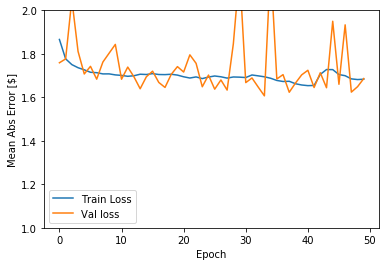

In [90]:
plot_history(history)

This graph shows little improvement in the model after about 100 epochs. Let's update the model.fit method to automatically stop training when the validation score doesn't improve. We'll use a callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

In [55]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([1,3])

In [56]:
modelP1 = build_model()

EPOCHS = 20
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs):
        if epoch % 20 == 0: print('')
        print('.', end='')
        
# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = modelP1.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.1, verbose=1,
                    callbacks=[early_stop])

Train on 34612 samples, validate on 3846 samples
Epoch 1/60
34612/34612 [==============================] - 2s 47us/step - loss: 31.2108 - mean_absolute_error: 2.9198 - val_loss: 13.9949 - val_mean_absolute_error: 2.1075
Epoch 2/60
34612/34612 [==============================] - 1s 35us/step - loss: 23.2893 - mean_absolute_error: 2.2380 - val_loss: 16.2807 - val_mean_absolute_error: 2.4055
Epoch 3/60
34612/34612 [==============================] - 1s 35us/step - loss: 22.5051 - mean_absolute_error: 2.1488 - val_loss: 12.3493 - val_mean_absolute_error: 1.8217
Epoch 4/60
34612/34612 [==============================] - 1s 34us/step - loss: 21.9810 - mean_absolute_error: 2.0962 - val_loss: 12.1958 - val_mean_absolute_error: 1.7991
Epoch 5/60
34612/34612 [==============================] - 1s 35us/step - loss: 21.7116 - mean_absolute_error: 2.0657 - val_loss: 11.6653 - val_mean_absolute_error: 1.9747
Epoch 6/60
34612/34612 [==============================] - 1s 36us/step - loss: 21.6470 - mean_ab

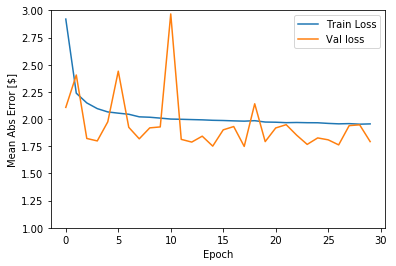

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline

plot_history(history)

The graph shows the average error is about \$1.75 dollars.

Let's see how did the model performs on the test set:

In [91]:
[loss, mae] = modelP1.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: ${:7.2f}".format(mae))

Testing set Mean Abs Error: $   1.69


## Predict

In [92]:
from sklearn.metrics import mean_squared_error
y_pred = modelP1.predict(X_test).flatten()
print('RMSE: %.3f' % np.sqrt(mean_squared_error(y_pred,y_test)).round(3))

RMSE: 3.574
